### Importing dependencies

In [130]:
import keras
from keras import Sequential
from keras import layers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import os, shutil
from livelossplot import PlotLossesKeras

keras.__version__

'2.2.0'

In [45]:
!pwd

/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50


### Prepare data directories

Let's prepare directories for our datacut.
We'll use a fraction of the full dataset. We'll keep our data organized into train, test, validation folders; each with separate dogs and cats subfolders.


In [46]:
original_dataset_dir = '/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data'

# The directory where we will store our smaller dataset
base_dir = '/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small'

# We want to keep our data organized into train, test, validation folders, each with separate dogs and cats subfolders
categories = ['cats', 'dogs']
str_train_val_test = ['train','validation', 'test']
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
    print('Created directory: ', base_dir)
        
for dir_type in str_train_val_test:
    train_test_val_dir = os.path.join(base_dir, dir_type)

    if not os.path.exists(train_test_val_dir):
        os.mkdir(train_test_val_dir)

    for category in categories:
        dir_type_category = os.path.join(train_test_val_dir, category)
        
        if not os.path.exists(dir_type_category):
            os.mkdir(dir_type_category)
            print('Created directory: ', dir_type_category)
  

### Organise train/validation/test data

In [47]:
directories_dict = {} # To store directory paths for data subsets.

for range_, dir_type in zip([range(1000), range(1000, 1500), range(1500, 2000)], str_train_val_test):
    for _, category in enumerate(categories):
        fnames = [category[:-1] + "." + str(i) + "." + "jpg" for i in range_]
        

        if _ == 0:
                directories_dict[str(dir_type)+ "_dir"] = os.path.join(base_dir, 
                                                                       dir_type, 
                                                                       )                          
        for _, fname in enumerate(fnames):
            
            if _ == 0:
                directories_dict[str(dir_type)+ "_" +str(category) + "_dir"] =  os.path.join(base_dir, 
                                                                                         dir_type, 
                                                                                         category)   
#             source = os.path.join(original_dataset_dir, fname)
#             destination = os.path.join(base_dir, dir_type, category, fname)
            
            
#             shutil.copyfile(source, destination)

In [48]:
directories_dict

{'test_cats_dir': '/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small/test/cats',
 'test_dir': '/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small/test',
 'test_dogs_dir': '/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small/test/dogs',
 'train_cats_dir': '/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small/train/cats',
 'train_dir': '/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small/train',
 'train_dogs_dir': '/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small/train/dogs',
 'validation_cats_dir': '/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small/validation/cats',
 'validation_dir': '/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small/validation',
 'validation_dogs_dir': '/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small/validation/dogs'}

In [49]:
print('Total training cat images:', len(os.listdir(directories_dict['train_cats_dir'])))
print('Total training dog images:', len(os.listdir(directories_dict['train_cats_dir'])))
print("-"*32)
print('Total test cat images:', len(os.listdir(directories_dict['test_cats_dir'])))
print('Total test dog images:', len(os.listdir(directories_dict['test_dogs_dir'])))
print("-"*32)
print('Total validation cat images:', len(os.listdir(directories_dict['validation_cats_dir'])))
print('Total validation dog images:', len(os.listdir(directories_dict['validation_dogs_dir'])))


Total training cat images: 1000
Total training dog images: 1000
--------------------------------
Total test cat images: 500
Total test dog images: 500
--------------------------------
Total validation cat images: 500
Total validation dog images: 500


### Create Keras data generators 

[text on data generators]

In [51]:
train_datagen = ImageDataGenerator(
    rescale=1 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1 / 255)

train_generator = test_datagen.flow_from_directory(
    directories_dict['train_dir'],
    target_size=(197, 197),
    batch_size=20,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    directories_dict['validation_dir'],
    target_size=(197, 197),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Import pre-trained ResNet 

In [70]:
from keras.applications import ResNet50
K.set_learning_phase(0) # see https://github.com/keras-team/keras/issues/9214  and https://github.com/keras-team/keras/pull/9965


conv_base = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(197, 197, 3),
    pooling='avg'
)

conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 203, 203, 3)  0           input_16[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 99, 99, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 99, 99, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [54]:
len(conv_base.layers)

175

In [67]:
len(conv_base.trainable_weights)

212

In [13]:
# #popping the 5th block...
# for i in range(32):
#     conv_base.layers.pop(-2)

In [14]:
# for i, layer in enumerate(conv_base.layers):
#     if < 32:
#         conv_base.layers.pop()

In [15]:
# for i, layer in enumerate(conv_base.layers):
#     if i < 81:
#         conv_base.layers.pop()

In [16]:
# # 5th block ON, the rest OFF
# for i, layer in enumerate(conv_base.layers):
#     layer.trainable = i > len(conv_base.layers)-66
#     print(layer.name, layer.trainable)



In [17]:
# # 4th block made trainable, the rest frozen

# for i, layer in enumerate(conv_base.layers):
#     layer.trainable = i > len(conv_base.layers)-65
#     print(layer.name, layer.trainable)



In [18]:
# # 5th block ON, the rest OFF
# for i, layer in enumerate(conv_base.layers):
#     layer.trainable = i > len(conv_base.layers)-33
#     print(layer.name, layer.trainable)


# # ALL OFF (not trainable)
# for layer in conv_base.layers:
#     layer.trainable = False


In [84]:
len(conv_base.trainable_weights)

0

In [71]:
conv_base.trainable = False

### Add two dense layers 

In [96]:
K.set_learning_phase(1)

model = Sequential()
model.add(conv_base)
# model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
# 
# model.add(layers.Dense(2, activation='softmax'))
# 

In [97]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_21 (Dense)             (None, 64)                131136    
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 23,718,913
Trainable params: 131,201
Non-trainable params: 23,587,712
_________________________________________________________________


In [98]:
len(model.trainable_weights)

4

In [99]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '0' 

# model.compile(loss='binary_crossentropy',
#               optimizer=keras.optimizers.RMSprop(lr= 1e-5),
#               metrics=['acc'])

In [100]:
# model.compile(loss='binary_crossentropy',
              
#               optimizer=keras.optimizers.adagrad(),
#               metrics=['acc'])

### Compile the model

In [101]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0' 

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=1e-5), #1e-4 performs well too
              metrics=['acc'])

In [114]:
model_checkpoint_dir = "./output"

if not os.path.exists(model_checkpoint_dir):
    os.mkdir(model_checkpoint_dir)
    print('Created directory: ', model_checkpoint_dir)

model_checkpoint_dir = model_checkpoint_dir + "/best_model.hdf5"


In [115]:
!ls

data	    output				   test1.zip
data_big    )))))))))))Resnet50-Keras-Copy1.ipynb  train.zip
data_small  Resnet50-Keras.ipynb
model.h5    Resnet50-PyTorch.ipynb


Keras API allows us to easily save the model architecture at the stage it reaches the best validation accuracy (or any metric we want to optimize for). The saving is done through ModelCheckpoint callback.

In [123]:
checkpoint_save_best = ModelCheckpoint(model_checkpoint_dir, monitor='val_acc',
verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)

SyntaxError: keyword argument repeated (<ipython-input-123-548ed012d5d9>, line 2)

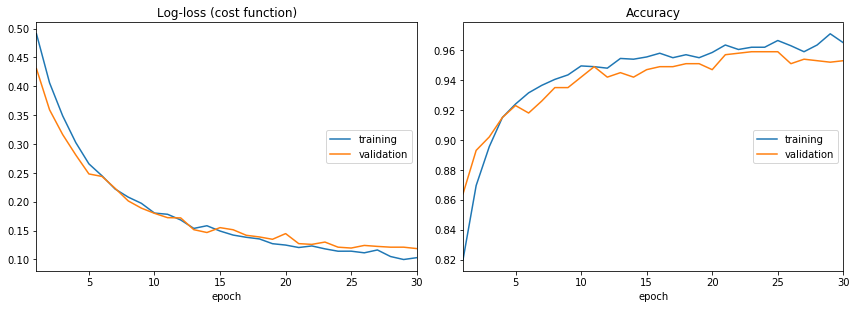


Epoch 00030: val_acc did not improve from 0.95900


In [117]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
        callbacks=[PlotLossesKeras(),
                   checkpoint_save_best])

### Loading model and evaluation 

In [178]:
from keras.backend import clear_session
clear_session()


In [179]:
loaded_model = load_model(model_checkpoint_dir, compile=False) #compile causes issues if not turned off - we are not training the model so we don't need to compile the model #the workaround to this user warning error might be to set all weights to not-trainable explicitly (in a loop) https://stackoverflow.com/questions/49195189/error-loading-the-saved-optimizer-keras-python-raspberry
print("Model loaded successfully!")

Model loaded successfully!


In [180]:
test_cat = "/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small/test/cats/cat.1505.jpg"

In [181]:
img = image.load_img(test_cat, target_size=(197, 197))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
preds = loaded_model.predict(x)
pred_class = loaded_model.predict_classes(x)

if pred_class[0][0] == 0:
    print("IT'S A CAT! ({:.2})".format(preds[0][0]))
else:
    print("IT'S A DOG! ({:.2})".format(preds[0][0]))

IT'S A CAT! (0.0005)


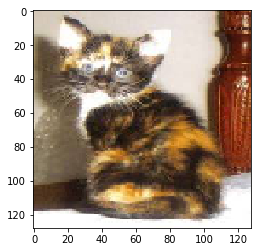

In [182]:
img = img.resize((128,128))
plt.imshow(img)
plt.show()

In [172]:
class_pred = loaded_model.predict_classes(x)

SyntaxError: invalid syntax (<ipython-input-172-30a905a9b31e>, line 1)

In [171]:
loaded_model.predict_classes(x)

Object `predict_classes` not found.


In [38]:
model.trainable_weights

[<tf.Variable 'dense_1/kernel:0' shape=(2048, 1) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32_ref>]

In [ ]:
K.set_learning_phase(0)
inputs = Input(...)
x = layer1(...)(inputs)
x = layer2(...)(x)
...
x = layerN(...)(x)

# Add training-mode layers
K.set_learning_phase(1)
x = layerNp1(...)(x)
x = layerNp2(...)(x)

In [42]:
import gc
import sys
 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import *
from keras import applications as apps
from keras import optimizers as opt
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical
 
def setup_to_transfer_learn(model, base_model) -> 'model':
    """Setup the models for transfer learning"""
    for layer in base_model.layers:
        layer.trainable = False
 
    model.compile(
        optimizer='rmsprop',    
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
   
    return model
 
 
def setup_to_finetune(model, n) -> 'model':
    """Setup the models for finetunning."""
    # Setting everything bellow n to be not trainable
    for i, layer in enumerate(model.layers):
            layer.trainable = i > n
 
    model.compile(
        optimizer=opt.SGD(lr=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
 
    return model
 
 
def main():
    filename_model_json = 'model.json'
    filename_model_weights = 'model.h5'
    batch_size = 16
    num_classes = 2
    steps_train = (2000/256)
    steps_test = (1000/256)
 
    base_model = apps.resnet50.ResNet50(include_top=False)
    ppf = apps.resnet50.preprocess_input
 
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    pred = Dense(num_classes, activation='relu')(x)
    model = Model(inputs=base_model.input, outputs=pred)
   
    train_gen = ImageDataGenerator(
        #preprocessing_function=ppf,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
 
    train_gen = train_gen.flow_from_directory(
        directories_dict['train_dir'],
        target_size=(224,224),
        class_mode='categorical',
        batch_size=batch_size
    )
 
    test_gen = ImageDataGenerator(
        #preprocessing_function=ppf
        #rescale=1./255
    )
 
    test_gen = test_gen.flow_from_directory(
        directories_dict['validation_dir'],
        target_size=(224,224),
        class_mode='categorical',
        batch_size=batch_size
    )
 
    model = setup_to_transfer_learn(model, base_model)
 
    model.fit_generator(
        train_gen,
        steps_per_epoch=steps_train,
        epochs=1,
        validation_data=test_gen,
        validation_steps=steps_test,
        class_weight='auto',
        
    )
 
    model = setup_to_finetune(model, len(base_model.layers)-1)
 
    chkpt_save_best = ModelCheckpoint(filename_model_weights, monitor='val_acc',
    verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    print("{} trainable weights".format(len(model.trainable_weights)))
    print("Finetuning...")
    model.fit_generator(
        train_gen,
        steps_per_epoch=steps_train,
        epochs=100,
        validation_data=test_gen,
        validation_steps=steps_test,
        class_weight='auto',
#         callbacks=[chkpt_save_best]
    )
 
#     # Saving the model structure and its weights
#     model_json = model.to_json()
#     with open(filename_model_json, 'w') as json_file:
#         json_file.write(model_json)
#     model.save_weights(filename_model_weights)
 
#     print(model.evaluate_generator(test_gen,10))
 
 
if __name__ == '__main__':
    main()

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/1
8/7 [==============================] - 15s 2s/step - loss: 8.6570 - acc: 0.2852 - val_loss: 6.4994 - val_acc: 0.5625
2 trainable weights
Finetuning...
Epoch 1/100
8/7 [==============================] - 15s 2s/step - loss: nan - acc: 0.6562 - val_loss: nan - val_acc: 0.6719
Epoch 2/100
8/7 [==============================] - 1s 163ms/step - loss: nan - acc: 0.6484 - val_loss: nan - val_acc: 0.6719
Epoch 3/100
8/7 [==============================] - 2s 205ms/step - loss: nan - acc: 0.6250 - val_loss: nan - val_acc: 0.6719
Epoch 4/100
8/7 [==============================] - 3s 355ms/step - loss: nan - acc: 0.6484 - val_loss: nan - val_acc: 0.6719
Epoch 5/100
8/7 [==============================] - 3s 349ms/step - loss: nan - acc: 0.6875 - val_loss: nan - val_acc: 0.6719
Epoch 6/100
8/7 [==============================] - 3s 323ms/step - loss: nan - acc: 0.6250 - val_loss: nan - val_acc: 0.6719
Epoch 7

In [ ]:
len(conv_base.layers)-31

In [ ]:
(all trainable)

In [ ]:
history.history['val_acc'] 

In [ ]:
[0.9569999921321869,
 0.9679999947547913,
 0.9679999959468841,
 0.9759999966621399,
 0.9749999964237213,
 0.9729999959468841,
 0.9599999916553498,
 0.9739999961853028,
 0.9719999945163726,
 0.9449999940395355]

In [ ]:
[0.9689999949932099,
 0.9709999942779541,
 0.9729999935626984,
 0.9679999935626984,
 0.9689999949932099,
 0.9729999947547913,
 0.9699999952316284,
 0.9719999933242798,
 0.9729999959468841,
 0.9759999942779541]


In [ ]:
[0.9569999921321869,
 0.9679999947547913,
 0.9679999959468841,
 0.9759999966621399,
 0.9749999964237213,
 0.9729999959468841,
 0.9599999916553498,
 0.9739999961853028,
 0.9719999945163726,
 0.9449999940395355]

In [ ]:
layers[-31:]

In [ ]:
Goal: 99% 